In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
! pip install rasterio  -q -q -q
! pip install geopandas -q -q -q
! pip install matplotlib -q -q -q
! pip install pyarrow
! pip install opencv-python

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.9/34.9 MB 7.5 MB/s eta 0:00:0000:0100:01m


mettre à jour OpenCV

In [ ]:
! sudo apt-get update
! sudo apt-get install ffmpeg libsm6 libxext6 -y
! sudo apt-get install libgl1

In [2]:
import sys
sys.path.append('../src')
from satellite_image import SatelliteImage
from utils import *
from plot_utils import *
from mappings import *

In [3]:
import yaml
import re
import s3fs
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image as im
import re
from pyproj import Transformer
from datetime import date
import cv2

In [4]:
update_storage_access()

environment = get_environment()

root_path = get_root_path()

bucket = environment["bucket"]

path_s3_pleiades_data_2022_guyane = environment["sources"]["PLEIADES"][2022]["guyane"]
path_local_pleiades_data_2022_guyane = environment["local-path"]["PLEIADES"][2022]["guyane"]

path_local_bdtopo_data = environment["local-path"]["BDTOPO"][2022]["guyane"]
path_s3_bdtopo_data = environment["sources"]["BDTOPO"][2022]["guyane"]

fs = s3fs.S3FileSystem(client_kwargs={"endpoint_url": "https://minio.lab.sspcloud.fr"})



In [7]:
fs.download(
        rpath=f"{bucket}/{path_s3_pleiades_data_2022_guyane}",
        lpath=f"../{path_local_pleiades_data_2022_guyane}",
        recursive=True)

fs.download(
        rpath=f"{bucket}/{path_s3_bdtopo_data}",
        lpath=f"../{path_local_bdtopo_data}",
        recursive=True
)


In [5]:
filename = '../data/PLEIADES/2022/GUYANE/ORT_2022072050325085_0353_0545_U22N_16Bits.jp2'
date = datetime.strptime(re.search(r'ORT_(\d{8})', filename).group(1), '%Y%m%d')

In [279]:
image = SatelliteImage.from_raster(
        filename,
        date = date, 
        n_bands = 4,
        dep = '973'
    )

In [7]:
list_images = image.split(256)

In [8]:
list_images[0].normalize()

Text(0, 0.5, 'Pixels Lignes')

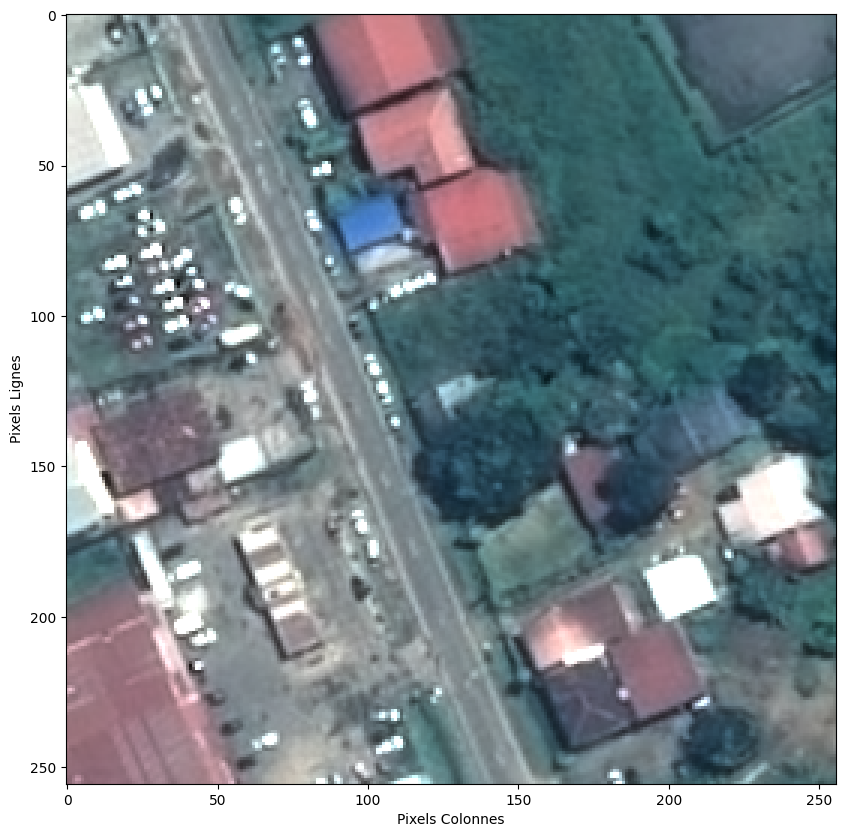

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(list_images[0].array, (1, 2, 0))[:,:,:3])
plt.xlabel('Pixels Colonnes')
plt.ylabel('Pixels Lignes')

In [97]:
from labeler import RILLabeler
from labeled_satellite_image import SegmentationLabeledSatelliteImage

labeler = RILLabeler(date, '973')

In [98]:
import rasterio
rasterio.coords.BoundingBox(10,10,10,11)

BoundingBox(left=10, bottom=10, right=10, top=11)

In [99]:
mask = labeler.create_segmentation_label(image)

Warning to remove

In [78]:
image.bounds

BoundingBox(left=353000.0, bottom=544000.0, right=354000.0, top=545000.0)

In [95]:
image.normalize()

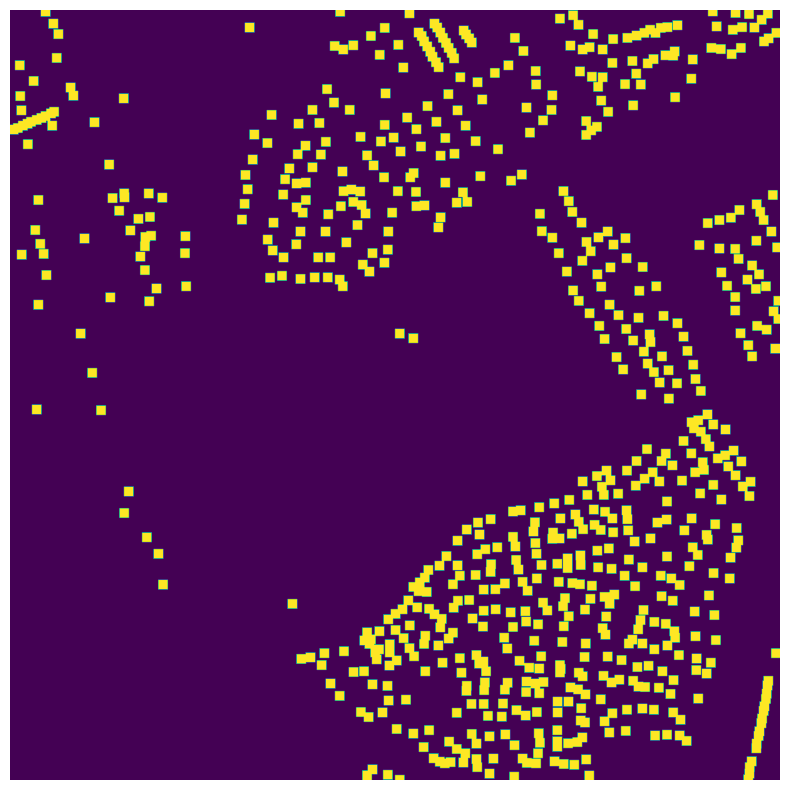

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mask)
# Enlever les axes
ax.set_axis_off()

# Enregistrer le plot sans les axes
plt.savefig("masqueRIL.png", bbox_inches="tight", pad_inches=0)

C'est le même résultat que dans le notebook de Clément

In [81]:
from labeled_satellite_image import DetectionLabeledSatelliteImage
label = labeler.create_detection_label(image)

In [82]:
len(label)

513

In [83]:
from shapely.geometry import box
import geopandas as gpd

boxes = []
for bounding_coordinates in label:
    boxes.append(box(*bounding_coordinates))
g = gpd.GeoSeries(boxes)

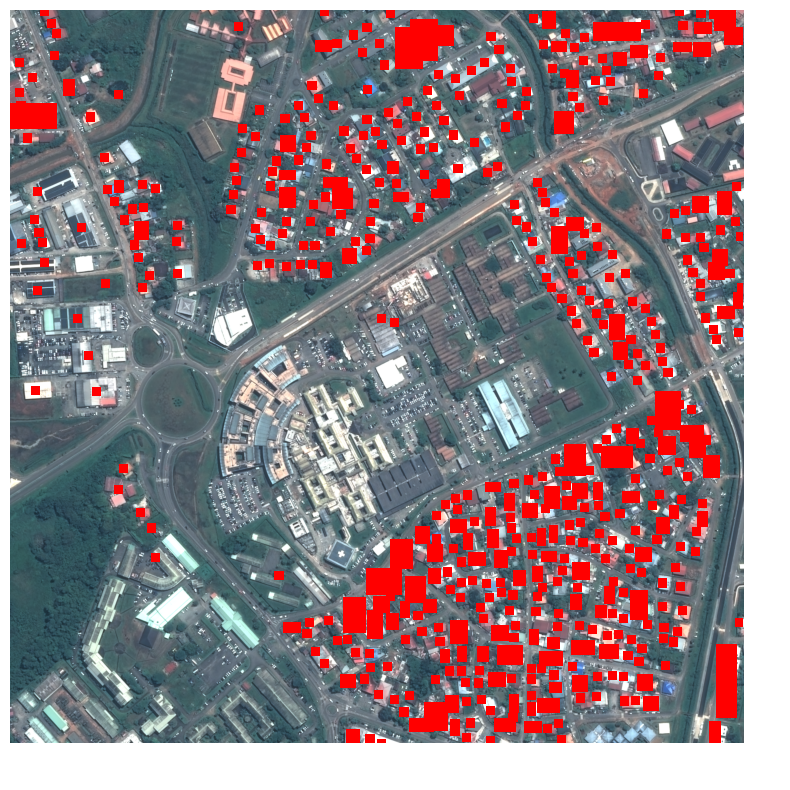

In [85]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
g.plot(color="red", ax=ax)
# Enlever les axes
ax.set_axis_off()

# Enregistrer le plot sans les axes
plt.savefig("masqueRIL.png", bbox_inches="tight", pad_inches=0)

BDTOPO

In [276]:
from labeler import BDTOPOLabeler

labeler = BDTOPOLabeler(date, '973')

In [277]:
mask = labeler.create_segmentation_label(image)

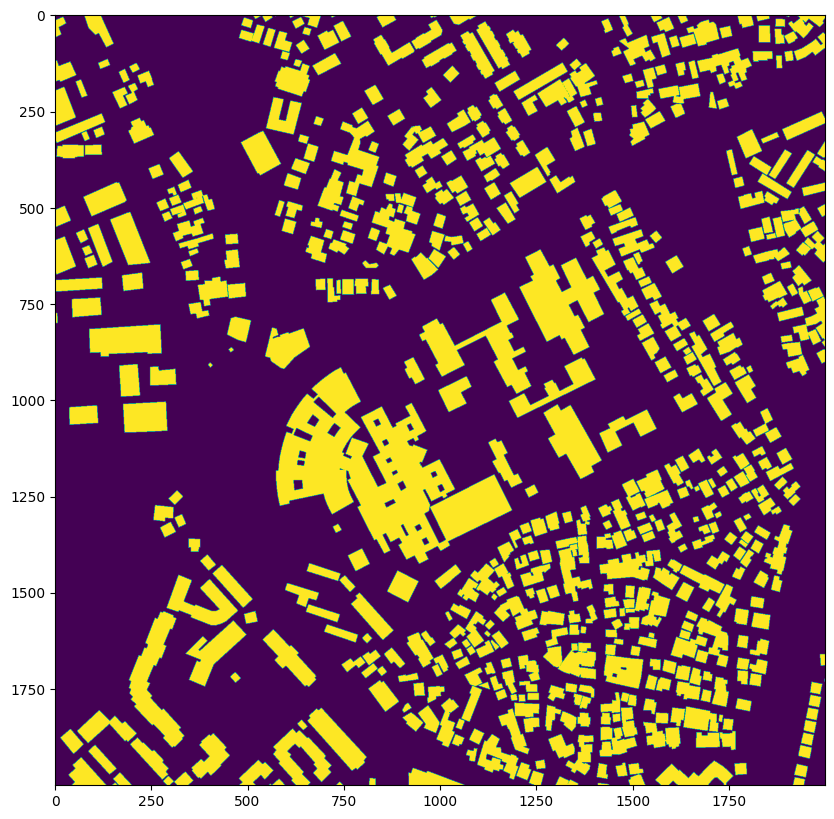

In [148]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(mask)

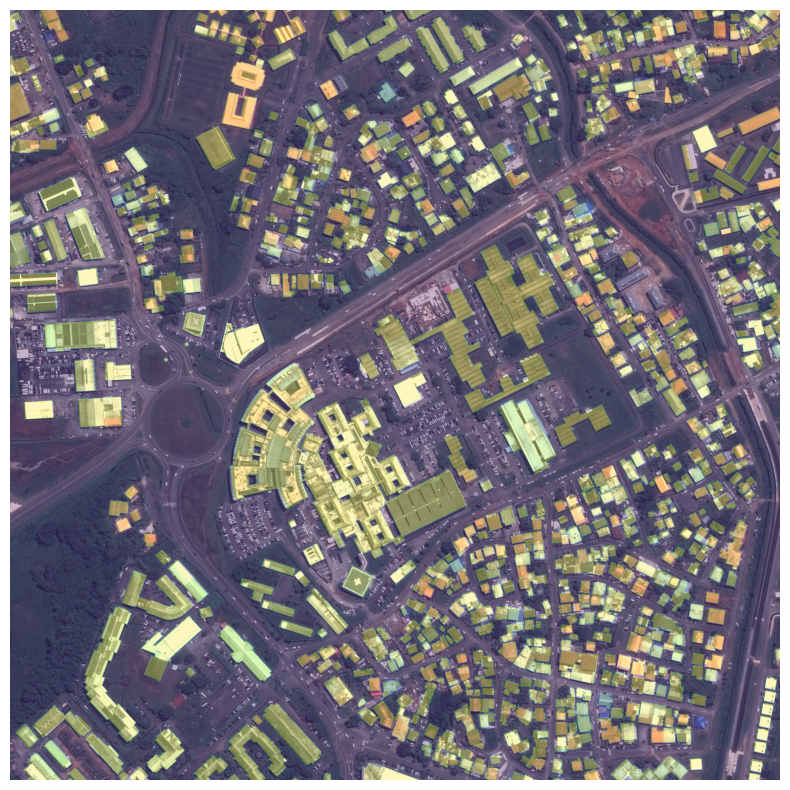

In [186]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
ax.imshow(mask, alpha=0.3)
# Enlever les axes
ax.set_axis_off()

# Enregistrer le plot sans les axes
plt.savefig("masqueBDTOPO.png", bbox_inches="tight", pad_inches=0)

Essayons de fusionner les deux masques

In [90]:
#images en nuances de gris
def cv2_imshow(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_RGBA2BGRA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)

    return plt.imshow(a, **kwargs, cmap= "gray")

#images en couleurs
def cv2_imshow2(a, **kwargs):
    a = a.clip(0, 255).astype('uint8')
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_RGBA2BGRA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_RGB2BGR)

    return plt.imshow(a, **kwargs, cmap= "brg")

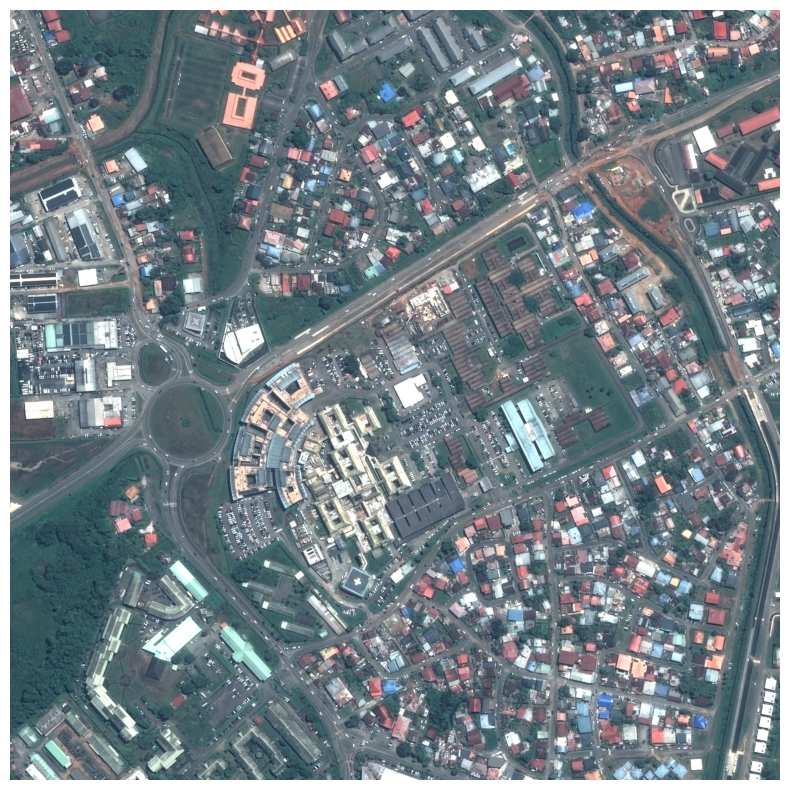

In [197]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])

# Enlever les axes
ax.set_axis_off()
# Enregistrer le plot sans les axes
plt.savefig("image.png", bbox_inches="tight", pad_inches=0)

In [137]:
img_RIL = cv2.imread("masqueRIL.png")

In [138]:
img_RIL = cv2.resize(img_RIL, (2000,2000))

In [143]:
#image RIL binaire
# On va parcourir tous les pixels de l'image
    
for row in range(img_RIL.shape[0]):
    for col in range(img_RIL.shape[1]):
        
        if list(img_RIL[row,col]) != [84, 1, 68] :
                img_RIL[row, col] = [255, 255, 255] # blanc

        else : 
            img_RIL[row, col] = [0,0,0] #noir

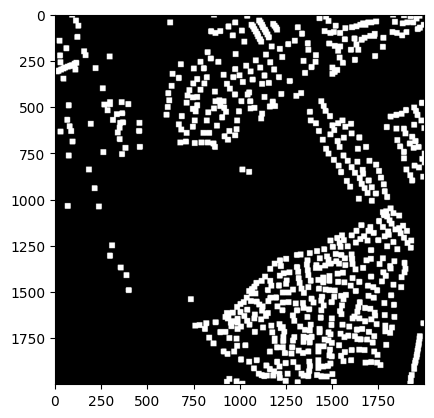

In [145]:
cv2_imshow2(img_RIL)

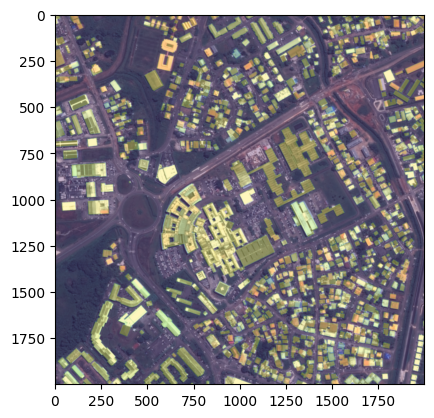

In [278]:
cv2_imshow(img_BDTOPO)

In [173]:
image_height = image.array.shape[1]
image_width = image.array.shape[2]
segmentation_mask = mask

polygon_list = []
index_polygon = []
for shape in list(shapes(segmentation_mask)):
    polygon = Polygon(shape[0]["coordinates"][0])
    if polygon.area > 0.85 * image_height * image_width:
        continue
    polygon_list.append(polygon)
    index_polygon.append(list(shapes(segmentation_mask)).index(shape))
    
g = gpd.GeoSeries(polygon_list)
clipped_g = gpd.clip(g, (0, 0, image_height, image_width))

label = [polygon.bounds for polygon in clipped_g]

KeyboardInterrupt: 

In [185]:
filter([i in new_index for i,value in enumerate(shapes(mask))], shapes(mask))


In [220]:
label = labeler.create_detection_label(image)

In [169]:
from shapely import Polygon
from rasterio.features import rasterize, shapes

In [175]:
new_index = []
for bounding_coordinates in label:
    left, bottom,right, top = bounding_coordinates
    for x  in range(int(left)-1,int(right)):
        for y  in range(int(bottom)-1,int(top)):
            if list(img_RIL[x,y]) == [255,255,255]: #blanc
                new_index.append(label.index(bounding_coordinates))

In [212]:
new_bounding_coordinates = []

for bounding_coordinates in label:
    mustEnd = False
    left, top,right, bottom = bounding_coordinates
    for x  in range(int(left)-1,int(right)):
        for y  in range(int(bottom)-1,int(top)):
            if mustEnd == False:
                if list(img_RIL[x,y]) == [255,255,255]: #blanc
                    new_bounding_coordinates.append(bounding_coordinates)
                    mustEnd = True
                    break
            else: 
                break

In [286]:
#on extrait l'array de l'image pour avoir les valeurs des pixels
img_base = image.array

#multiplication par 255 et convertion en uint8 pour avoir le bon format
img_base = (img_base * 255).astype(np.uint8)

img_base = img_base.transpose()

In [287]:
img_base

array([[[129,  91,  62, 249],
        [124,  87,  59, 245],
        [136,  97,  70, 255],
        ...,
        [232,  64,  21, 236],
        [228,  58,  15, 228],
        [248,  87,  48,  79]],

       [[ 95,  59,  31, 214],
        [ 88,  50,  23, 207],
        [123,  87,  62, 247],
        ...,
        [255, 110,  73, 139],
        [255, 101,  63, 121],
        [246,  86,  46,  78]],

       [[ 98,  63,  37, 221],
        [ 77,  41,  15, 198],
        [114,  76,  53, 238],
        ...,
        [255, 118,  82, 168],
        [  5, 127,  91, 210],
        [241,  77,  38,  52]],

       ...,

       [[157, 249, 198, 208],
        [159, 255, 204, 206],
        [162, 255, 206, 205],
        ...,
        [ 67, 249, 207, 190],
        [ 65, 246, 202, 189],
        [ 61, 242, 197, 183]],

       [[167, 243, 192, 208],
        [167, 246, 195, 202],
        [172, 248, 197, 200],
        ...,
        [ 58, 245, 201, 202],
        [ 50, 235, 190, 184],
        [ 46, 229, 183, 173]],

       [[183

In [285]:
img_base

array([[[0.50617284, 0.3744856 , 0.38683128, ..., 0.61728395,
         0.65843621, 0.72016461],
        [0.48971193, 0.34567901, 0.30452675, ..., 0.6255144 ,
         0.65843621, 0.71193416],
        [0.53497942, 0.48559671, 0.44855967, ..., 0.63786008,
         0.67489712, 0.72839506],
        ...,
        [0.91358025, 1.        , 1.        , ..., 0.26337449,
         0.23045267, 0.20576132],
        [0.89711934, 1.        , 0.02057613, ..., 0.25514403,
         0.19753086, 0.14814815],
        [0.97530864, 0.96707819, 0.94650206, ..., 0.24279835,
         0.18106996, 0.11111111]],

       [[0.35772358, 0.23170732, 0.24796748, ..., 0.9796748 ,
         0.95528455, 0.92682927],
        [0.34146341, 0.19918699, 0.16260163, ..., 1.        ,
         0.96747967, 0.93089431],
        [0.38211382, 0.34146341, 0.30081301, ..., 1.        ,
         0.97560976, 0.93495935],
        ...,
        [0.25203252, 0.43495935, 0.46341463, ..., 0.9796748 ,
         0.96341463, 0.94715447],
        [0.2

In [281]:
for bounds in new_bounding_coordinates:
    left, bottom,right, top = bounds
    for u  in range(int(left)+1,int(right)):
        for v  in range(int(bottom)+1,int(top)):
            R,G,B = img_BDTOPO[u,v]
            img_base[u,v] = np.array([R,G,B,img_base[u,v][3]])

In [282]:
img_base = img_base.transpose()

#On veut le bon format
img_base = (img_base/255).astype(np.float64)

image.array = img_base

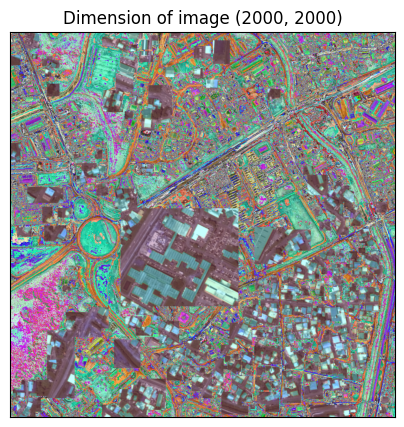

In [283]:


image.plot([0,1,2])



####################

In [160]:
from shapely.geometry import box
import geopandas as gpd

boxes = []
for bounding_coordinates in new_label:
    boxes.append(box(*bounding_coordinates))
g = gpd.GeoSeries(boxes)


<Axes: >

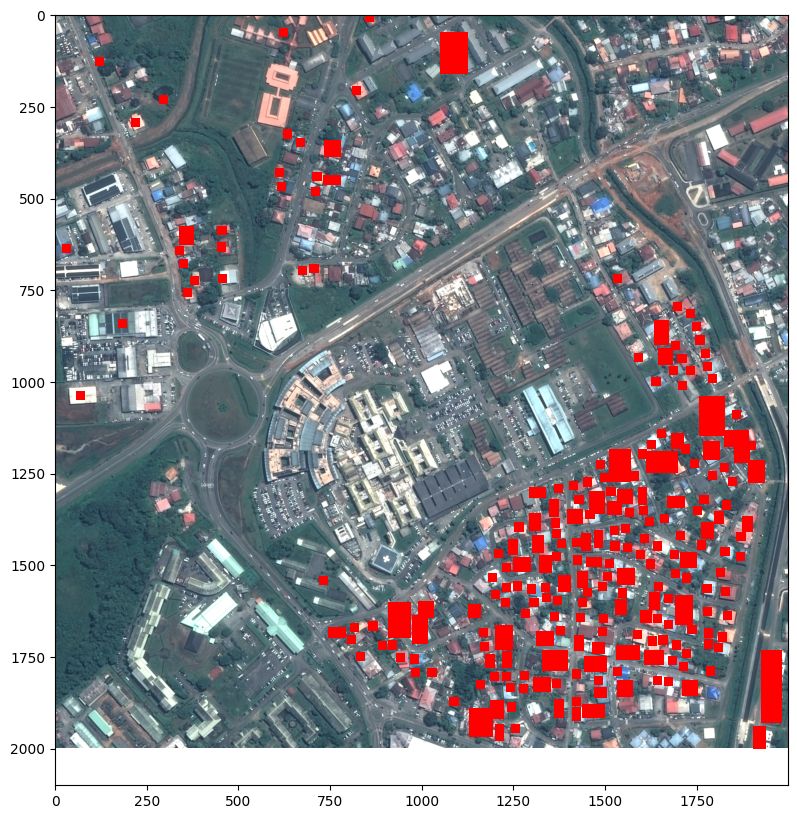

In [161]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(np.transpose(image.array, (1, 2, 0))[:,:,:3])
g.plot(color="red", ax=ax)